In [124]:
# Imports
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pickle
from scipy.stats import t
import dask.dataframe as dd
import matplotlib.cm as cm

# Explore the behaviours of malicious users 
1. PCA: Malicious VS Non-Malicious

- PCA loadings help identify key behaviors and personality traits that define variance in user activity data.
- Behaviors include file copying and domain interactions; personality traits are derived from the OCEAN model.
- Comparative analysis of PCA loadings between malicious and non-malicious users reveals distinct patterns:
  - Certain features are more prominent among malicious users, differentiating their behavior from non-malicious users.


In [268]:
# Processed folder
processed_dir = os.path.join( "..", "data", "processed")
final_dataset_path = os.path.join(processed_dir, 'FEData_For_Modelling.parquet')
highimportancepcafeatures_path = os.path.join(processed_dir, 'highimportance_PCAfeatures_graph.pickle')

minority_users_dt_pq = os.path.join(processed_dir, 'minority_users_dt.parquet')
minority_users_smote_dt_pq = os.path.join(processed_dir, 'minority_users_dt_smote.parquet')

minority_users_svm_pq = os.path.join(processed_dir, 'minority_users_svm.parquet')
minority_users_smote_svm_pq = os.path.join(processed_dir, 'minority_users_svm_smote.parquet')

minority_users_nn_pq = os.path.join(processed_dir, 'minority_users_nn.parquet')
minority_users_smote_nn_pq = os.path.join(processed_dir, 'minority_users_nn_smote.parquet')


# Figures folder
figures_dir = os.path.join( "..", "materials", "reports", "figures", "5")
pca_all_path = os.path.join(figures_dir, 'pca_all.png')
pca_non_mal_path = os.path.join(figures_dir, 'pca_non_mal.png')
pca_mal_path = os.path.join(figures_dir, 'pca_mal.png')

FP_Analysis_Boxplots_path = os.path.join(figures_dir, 'FP_Analysis_Boxplots.png')
FP_Analysis_Bar_path = os.path.join(figures_dir, 'FP_Analysis_Bar.png')


In [75]:
# Read the multi-part Parquet dataset
data = pd.read_parquet(final_dataset_path).reset_index(drop = True)
data.head(4000)

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh,malicious
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246,False
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679,False
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025,False
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2,False
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494,False
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322,False
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7,False
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810,False


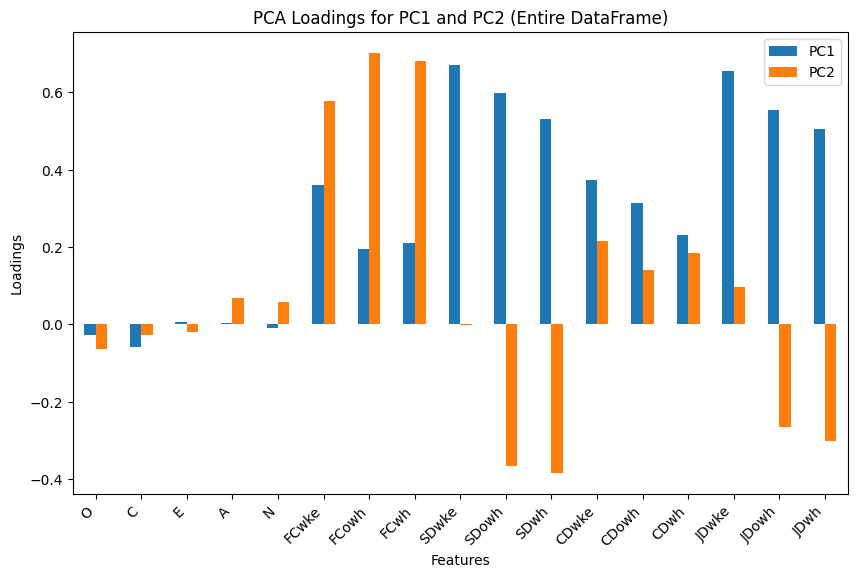

PCA Loadings for PC1 and PC2 (Entire DataFrame):
            PC1       PC2
O     -0.027438 -0.063714
C     -0.058659 -0.027575
E      0.006821 -0.018724
A      0.004482  0.069755
N     -0.008042  0.058521
FCwke  0.360245  0.578797
FCowh  0.196360  0.701848
FCwh   0.209770  0.682578
SDwke  0.672074 -0.000204
SDowh  0.597861 -0.366508
SDwh   0.532451 -0.384308
CDwke  0.372612  0.215637
CDowh  0.314416  0.140781
CDwh   0.232068  0.184068
JDwke  0.655284  0.095992
JDowh  0.553772 -0.265114
JDwh   0.505562 -0.300899


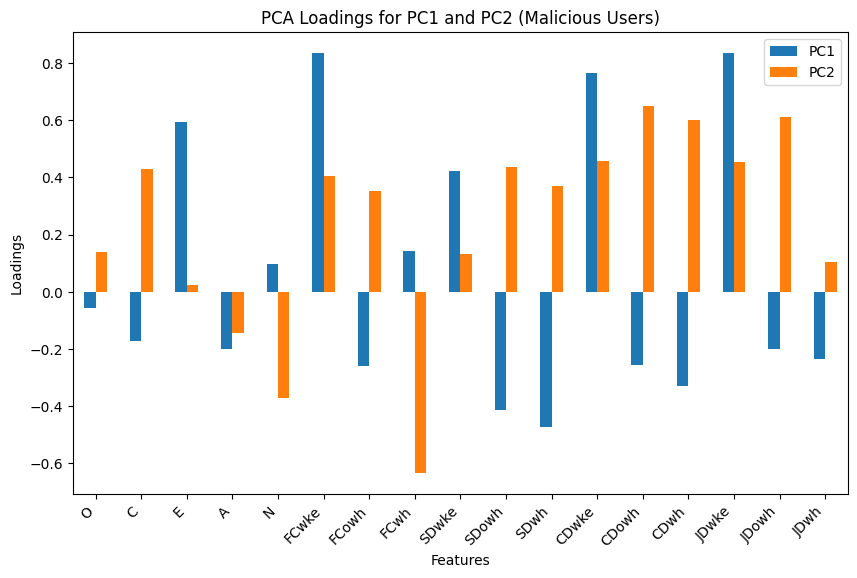

PCA Loadings for PC1 and PC2 (Malicious Users):
            PC1       PC2
O     -0.055193  0.138337
C     -0.172176  0.430476
E      0.592929  0.022325
A     -0.200634 -0.144464
N      0.098203 -0.370682
FCwke  0.834811  0.405964
FCowh -0.257898  0.351602
FCwh   0.144348 -0.633621
SDwke  0.421730  0.133880
SDowh -0.413102  0.438007
SDwh  -0.471289  0.368672
CDwke  0.763659  0.457594
CDowh -0.255594  0.649535
CDwh  -0.330020  0.602178
JDwke  0.834346  0.455694
JDowh -0.201083  0.610376
JDwh  -0.235523  0.105157


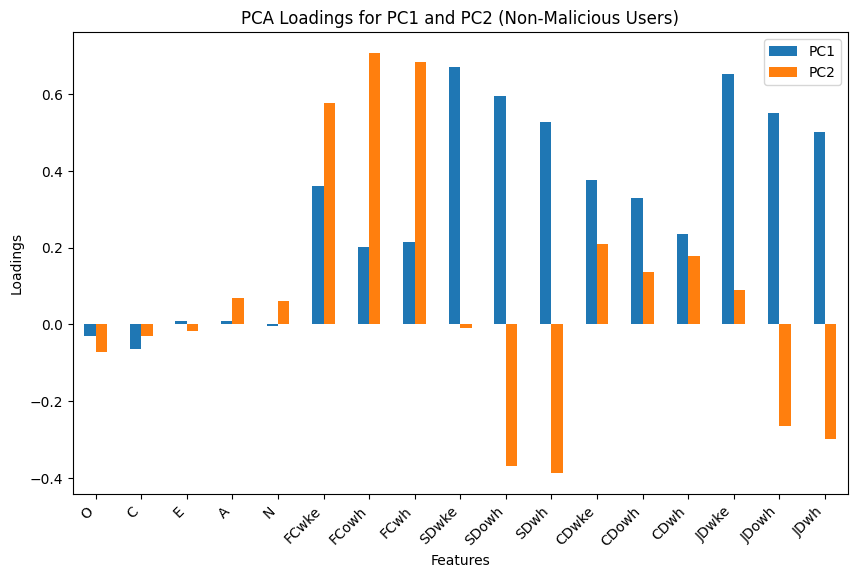

PCA Loadings for PC1 and PC2 (Non-Malicious Users):
            PC1       PC2
O     -0.029445 -0.070902
C     -0.064188 -0.030363
E      0.008781 -0.017228
A      0.007937  0.067690
N     -0.003798  0.061966
FCwke  0.361692  0.576643
FCowh  0.201905  0.707474
FCwh   0.214545  0.685535
SDwke  0.670831 -0.008116
SDowh  0.595759 -0.369703
SDwh   0.528727 -0.387623
CDwke  0.375698  0.209557
CDowh  0.329856  0.136683
CDwh   0.236599  0.178769
JDwke  0.654171  0.088809
JDowh  0.551634 -0.263972
JDwh   0.503005 -0.299445


In [77]:
pca_df = data.copy()
features = ['O', 'C', 'E', 'A', 'N', 'FCwke', 'FCowh', 'FCwh', 'SDwke', 'SDowh', 'SDwh', 'CDwke', 'CDowh', 'CDwh', 'JDwke', 'JDowh', 'JDwh']

X = pca_df[features]
X_std = (X - X.mean()) / X.std()

pca_all = PCA()
pca_all.fit(X_std)
loadings_all_pc1_pc2 = pca_all.components_[:2].T * np.sqrt(pca_all.explained_variance_[:2])

loadings_all_df = pd.DataFrame(loadings_all_pc1_pc2, columns=['PC1', 'PC2'], index=features)

plt.figure(figsize=(10, 6))
loadings_all_df.plot(kind='bar', ax=plt.gca())
plt.title('PCA Loadings for PC1 and PC2 (Entire DataFrame)')
plt.xlabel('Features')
plt.ylabel('Loadings')
plt.xticks(rotation=45, ha='right')
plt.savefig(pca_all_path)
plt.show()

print("PCA Loadings for PC1 and PC2 (Entire DataFrame):")
print(loadings_all_df)

malicious_df = pca_df[pca_df['malicious'] == 1]

X_malicious = malicious_df[features]
X_std_malicious = (X_malicious - X_malicious.mean()) / X_malicious.std()

pca_malicious = PCA()
pca_malicious.fit(X_std_malicious)
loadings_malicious_pc1_pc2 = pca_malicious.components_[:2].T * np.sqrt(pca_malicious.explained_variance_[:2])

loadings_malicious_df = pd.DataFrame(loadings_malicious_pc1_pc2, columns=['PC1', 'PC2'], index=features)

plt.figure(figsize=(10, 6))
loadings_malicious_df.plot(kind='bar', ax=plt.gca())
plt.title('PCA Loadings for PC1 and PC2 (Malicious Users)')
plt.xlabel('Features')
plt.ylabel('Loadings')
plt.xticks(rotation=45, ha='right')
plt.savefig(pca_mal_path)

plt.show()


print("PCA Loadings for PC1 and PC2 (Malicious Users):")
print(loadings_malicious_df)

non_malicious_df = pca_df[pca_df['malicious'] == 0]

X_nonmalicious = non_malicious_df[features]
X_std_nonmalicious = (X_nonmalicious - X_nonmalicious.mean()) / X_nonmalicious.std()

pca_nonmalicious = PCA()
pca_nonmalicious.fit(X_std_nonmalicious)
loadings_nonmalicious_pc1_pc2 = pca_nonmalicious.components_[:2].T * np.sqrt(pca_nonmalicious.explained_variance_[:2])

loadings_nonmalicious_df = pd.DataFrame(loadings_nonmalicious_pc1_pc2, columns=['PC1', 'PC2'], index=features)

plt.figure(figsize=(10, 6))
loadings_nonmalicious_df.plot(kind='bar', ax=plt.gca())
plt.title('PCA Loadings for PC1 and PC2 (Non-Malicious Users)')
plt.xlabel('Features')
plt.ylabel('Loadings')
plt.xticks(rotation=45, ha='right')
plt.savefig(pca_non_mal_path)

plt.show()


print("PCA Loadings for PC1 and PC2 (Non-Malicious Users):")
print(loadings_nonmalicious_df)


## PCA Loadings Analysis

### Entire DataFrame:
- **PC1**: Positive loadings for behaviors outside of standard work hours, especially `FCwke`, `SDwke`, `JDwke`.
- **PC2**: `FCowh`, `FCwh`, and `FCwke` have significant positive loadings; `SDowh` and `SDwh` show negative correlations.

### Malicious Users:
- **PC1**: High positive loadings for weekend activities (`FCwke`, `CDwke`, `JDwke`) and negative for some domain interactions (`SDowh`, `SDwh`).
- **PC2**: `C`, `CDowh`, `CDwh`, `JDowh`, and `FCowh` stand out with positive loadings; `N`, `FCwh`, and `A` are inversely related.

### Non-Malicious Users:
- **PC1 & PC2**: Loading patterns are similar to the entire dataset, suggesting consistent behaviors across all users.

### Comparative Insights:
- **Behavioral Patterns**: Malicious users' loadings highlight weekend and after-hours activities as significant behavior indicators.
- **OCEAN Traits**: Differences in `C` and `N` loadings between malicious and non-malicious users suggest a correlation with malicious behaviors.
- **Principal Component Focus**: For malicious users, PC1 emphasizes weekend activities, while PC2 captures a contrast between conscientiousness and domain activity against neuroticism and work hour activities.

These PCA loadings suggest that certain time-related behaviors and personality traits could be predictive of malicious activities.


In [78]:
df = data.copy()

Code below takes 1h to run, use G_highimportancePCAfeatures.pickle

In [ ]:
# Selecting the high importance features from PCA
high_importance_features = ['FCwke', 'CDwke', 'JDwke', 'SDowh', 'SDwh', 'C', 'CDowh', 'CDwh', 'JDowh', 'FCowh', 'N', 'FCwh', 'A']

# Create a new DataFrame with only the high importance features
high_importance_df = df[high_importance_features]

# Create a network graph
G_highimportancePCAfeatures = nx.Graph()

# Add nodes with color attribute based on maliciousness
node_color_map = {0: 'blue', 1: 'red'}
for i, row in df.iterrows():
    G_highimportancePCAfeatures.add_node(row['user'], color=node_color_map[row['malicious']])

# Adding edges between users based on similarity in high importance features
for i, row in high_importance_df.iterrows():
    print(i)
    for j in range(i+1, len(high_importance_df)):
        row2 = high_importance_df.iloc[j]
        similarity = sum(abs(row - row2))  # Manhattan distance
        if similarity < 20:  # Adjust threshold as needed
            G_highimportancePCAfeatures.add_edge(df.iloc[i]['user'], df.iloc[j]['user'], weight=similarity)

pickle.dump(G_highimportancePCAfeatures, open(highimportancepcafeatures_path, 'wb'))

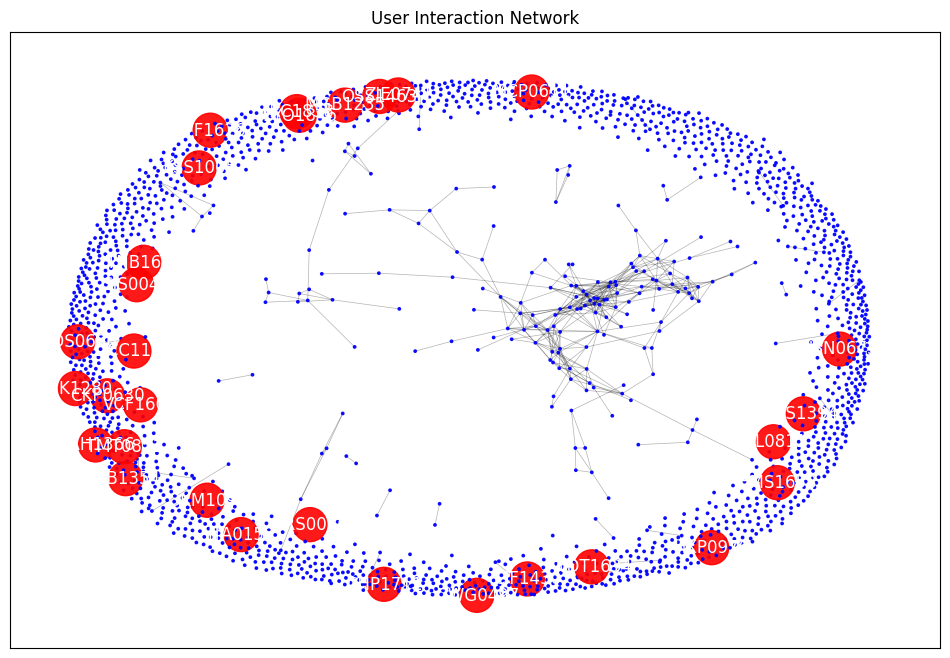

In [79]:
G_highimportancePCAfeatures = pickle.load(open(highimportancepcafeatures_path, 'rb'))
malicious_node_size = 600  # Larger size for visibility
default_node_size = 3
node_colors = [G_highimportancePCAfeatures.nodes[n]['color'] for n in G_highimportancePCAfeatures.nodes()]
node_sizes = [malicious_node_size if data['color'] == 'red' else default_node_size for _, data in G_highimportancePCAfeatures.nodes(data=True)]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_highimportancePCAfeatures, k=0.3, iterations=50)
nx.draw_networkx_nodes(G_highimportancePCAfeatures, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_edges(G_highimportancePCAfeatures, pos, alpha=0.3, width=0.5)
malicious_labels = {n: n if d['color'] == 'red' else '' for n, d in G_highimportancePCAfeatures.nodes(data=True)}
nx.draw_networkx_labels(G_highimportancePCAfeatures, pos, labels=malicious_labels, font_size=12, font_color='white')

plt.title('User Interaction Network')
plt.show()

# Analysis of Post Model Results

In [81]:
dt_data = pd.read_parquet(minority_users_dt_pq)
smote_dt_data = pd.read_parquet(minority_users_smote_dt_pq)

svm_data = pd.read_parquet(minority_users_svm_pq)
smote_svm_data = pd.read_parquet(minority_users_smote_svm_pq)

nn_data = pd.read_parquet(minority_users_nn_pq)
smote_nn_data = pd.read_parquet(minority_users_smote_nn_pq)

fds = data.copy()

In [125]:
# Define models and model names
models = [dt_data, smote_dt_data, svm_data, smote_svm_data, nn_data, smote_nn_data]
model_names = ["dt_data", "smote_dt_data", "svm_data", "smote_svm_data", "nn_data", "smote_nn_data"]
all = [dt_data, smote_dt_data, svm_data, smote_svm_data, nn_data, smote_nn_data, fds]

# Check and rename columns if needed
for model_data in all:
    if 'user' in model_data.columns:
        model_data.rename(columns={'user': 'User'}, inplace=True)

# Reset index for each model
for model_data in models:
    model_data.reset_index(drop=True, inplace=True)

# Filter fds to include only common users
common_users = set.intersection(*[set(model['User']) for model in models])
fds = fds[fds['User'].isin(common_users)].copy()

fds['fn'] = 0
fds['fp'] = 0
fds['tn'] = 0
fds['tp'] = 0

model_dfs = [dt_data, smote_dt_data, svm_data, smote_svm_data, nn_data, smote_nn_data]

# Function to update counts
def update_classification_counts(row, model_df):
    user = row['User']
    actual = row['malicious']
    model_row = model_df[model_df['User'] == user].iloc[0]
    prediction = model_row['Prediction']
    # Update true positives, false positives, etc.
    if actual and prediction:  # True Positive
        fds.loc[fds['User'] == user, 'tp'] += 1
    elif not actual and not prediction:  # True Negative
        fds.loc[fds['User'] == user, 'tn'] += 1
    elif not actual and prediction:  # False Positive
        fds.loc[fds['User'] == user, 'fp'] += 1
    elif actual and not prediction:  # False Negative
        fds.loc[fds['User'] == user, 'fn'] += 1

# Apply updates for each model
for model_df in model_dfs:
    fds.apply(update_classification_counts, axis=1, args=(model_df,))

fds

,User,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,...,CDowh,CDwh,JDwke,JDowh,JDwh,malicious,fn,fp,tn,tp
23,ACD1174,28,20,38,26,33,0,0,0,0,...,67,555,0,269,1398,False,0,0,6,0
29,ACH1840,20,24,15,45,37,0,0,0,0,...,0,0,0,0,3648,False,0,0,6,0
30,ACJ1797,23,32,19,26,32,0,0,0,6,...,0,0,0,0,0,False,0,0,6,0
32,ACR1045,40,38,10,25,30,0,0,0,0,...,0,0,0,53,262,False,0,0,6,0
44,AEF1032,25,44,48,18,30,0,0,0,0,...,0,0,0,39,239,False,0,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966,YVJ0986,43,48,15,25,23,0,0,0,0,...,0,6,0,27,316,False,0,0,6,0
1978,ZDH1266,41,44,35,43,29,0,0,0,0,...,0,5,0,9,133,False,0,0,6,0
1981,ZHB1104,34,14,23,18,31,0,0,0,0,...,2,10,0,37,87,False,0,0,6,0
1987,ZJT1601,10,50,38,10,35,0,58,213,0,...,9,38,0,177,542,False,0,0,6,0


# Deep Dive into False Positives

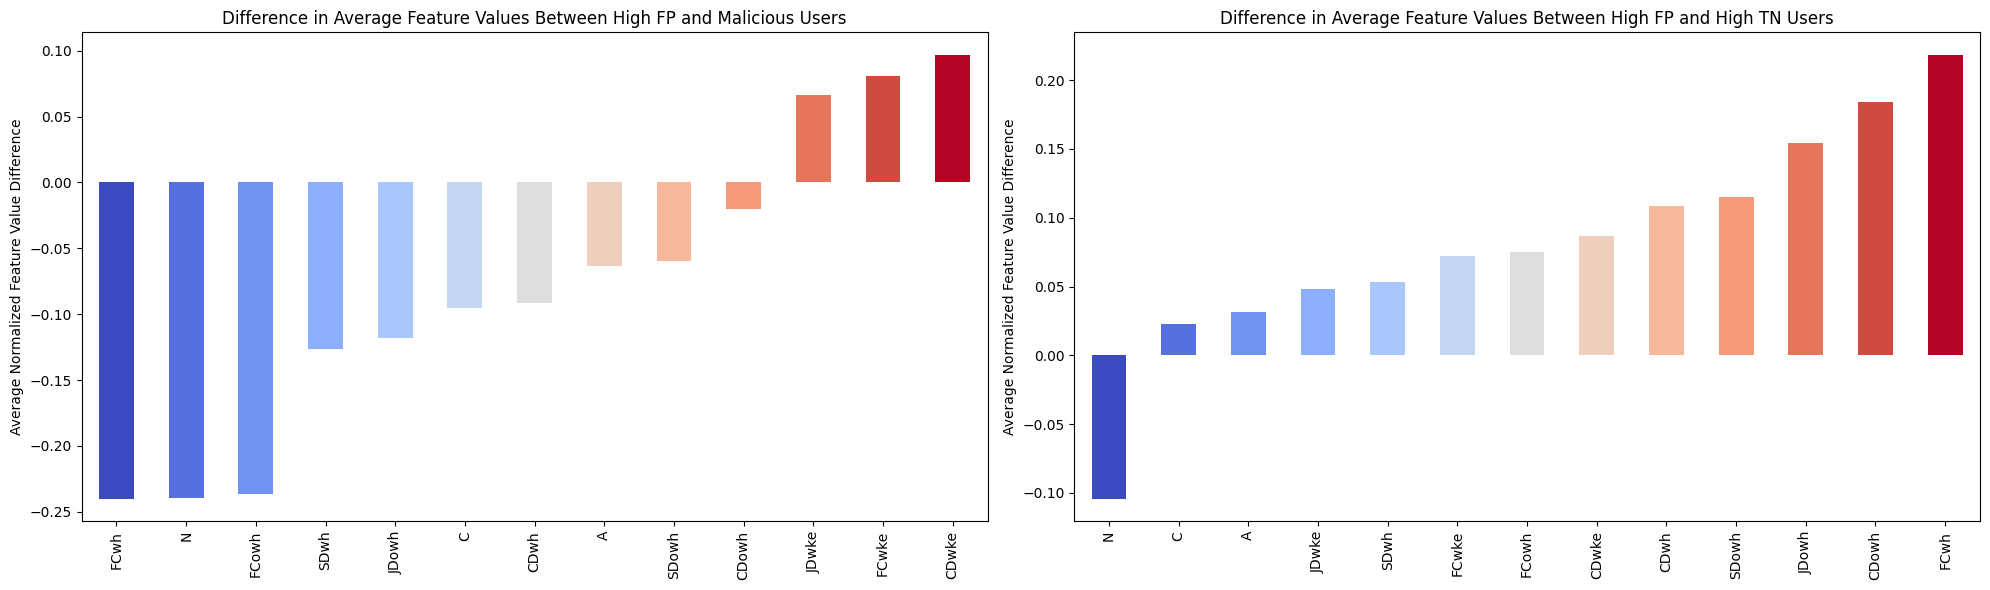

In [269]:
# Filter datasets
high_fp = fds[fds['fp'] >= 1]  # Users wrongly classified as malicious multiple times
high_tn = fds[fds['tn'] >= 5]  # Users correctly classified as non-malicious
mal = fds[fds['malicious'] == 1]  # Truly malicious users

# We want to see the similarities btwn fp and tn, why fp not classified as tn
# also similarities btwn fp and mal, why fp are classified as mal

# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Select features for each dataset
high_fp_features = high_fp[high_importance_features]
high_tn_features = high_tn[high_importance_features]
mal_features = mal[high_importance_features]

high_fp_features = scaler.fit_transform(high_fp_features)
high_fp_features = pd.DataFrame(high_fp_features, columns=high_importance_features)

# Scale features for high_tn dataset
high_tn_features = scaler.fit_transform(high_tn_features)
high_tn_features = pd.DataFrame(high_tn_features, columns=high_importance_features)

# Scale features for mal dataset
mal_features = scaler.fit_transform(mal_features)
mal_features = pd.DataFrame(mal_features, columns=high_importance_features)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

high_fp_means = high_fp_features[high_importance_features].mean()
mal_means = mal_features[high_importance_features].mean()
high_tn_means = high_tn_features[high_importance_features].mean()

feature_diff_fp_vs_tn = (high_fp_means - high_tn_means).sort_values()
feature_diff_fp_vs_mal = (high_fp_means - mal_means).sort_values()

feature_diff_fp_vs_mal.plot(kind='bar', color=color_map(np.linspace(0, 1, len(feature_diff_fp_vs_mal))), ax=axes[0])
axes[0].set_title('Difference in Average Feature Values Between High FP and Malicious Users')
axes[0].set_ylabel('Average Normalized Feature Value Difference')

feature_diff_fp_vs_tn.plot(kind='bar', color=color_map(np.linspace(0, 1, len(feature_diff_fp_vs_tn))), ax=axes[1])
axes[1].set_title('Difference in Average Feature Values Between High FP and High TN Users')
axes[1].set_ylabel('Average Normalized Feature Value Difference')

plt.tight_layout()
plt.savefig(FP_Analysis_Bar_path)
plt.show()

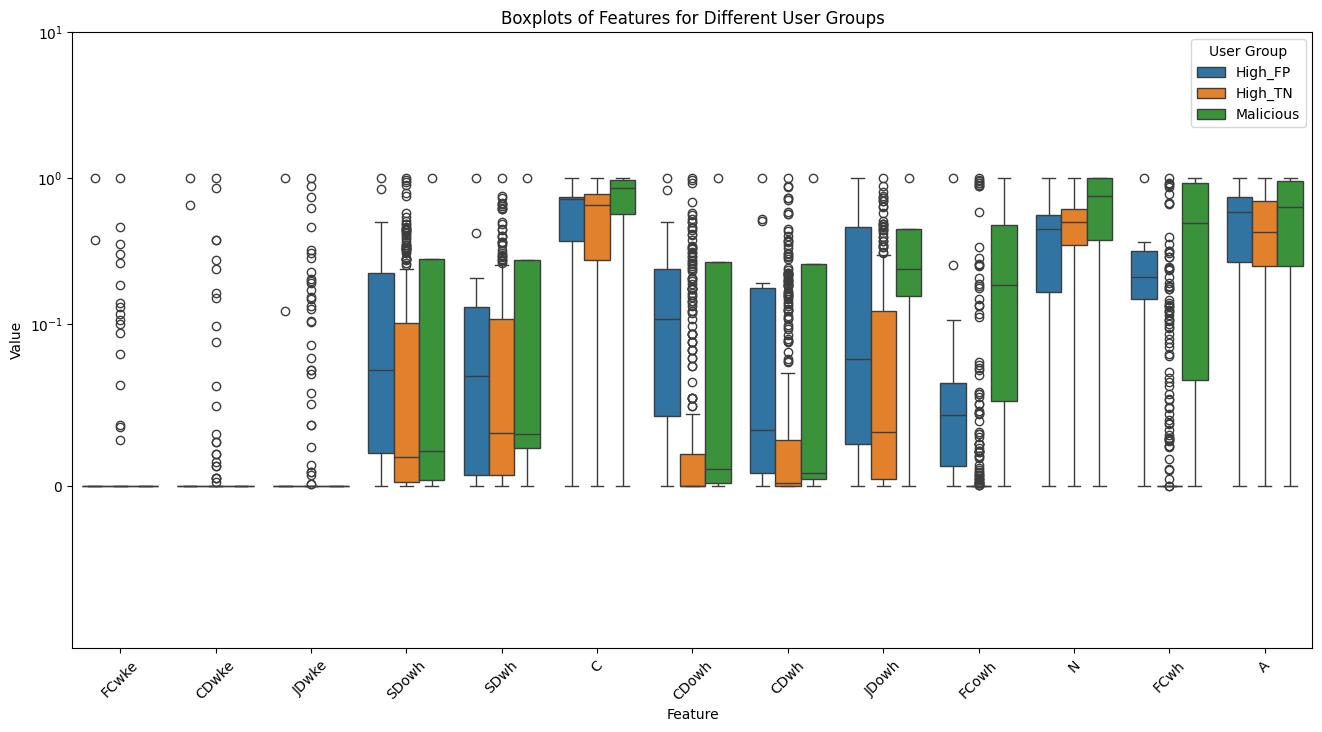

In [270]:
ft = ['SDwh', 'JDowh', 'CDwh', 'FCowh', 'FCwh']
ft = high_importance_features

high_fp_features = high_fp_features[ft]
high_tn_features = high_tn_features[ft]
mal_features = mal_features[ft]

combined_data = pd.concat([high_fp_features, high_tn_features, mal_features],
                          keys=['High_FP', 'High_TN', 'Malicious'])

# Melt the dataframe for easy plotting
melted_data = combined_data.reset_index().melt(id_vars=['level_0'], var_name='Feature', value_name='Value')
melted_data = melted_data[melted_data['Feature'] != 'level_1']

# Plot boxplots
plt.figure(figsize=(16, 8))
sns.boxplot(x='Feature', y='Value', hue='level_0', data= melted_data)
plt.title('Boxplots of Features for Different User Groups')
plt.xticks(rotation=45)
plt.yscale("symlog", linthresh=0.1)
plt.ylim(bottom = -1e-1,top=1e1)
plt.xlabel('Feature')
plt.ylabel('Value')
plt.legend(title='User Group')
plt.savefig(FP_Analysis_Boxplots_path)
plt.show()

# ARCHIVE


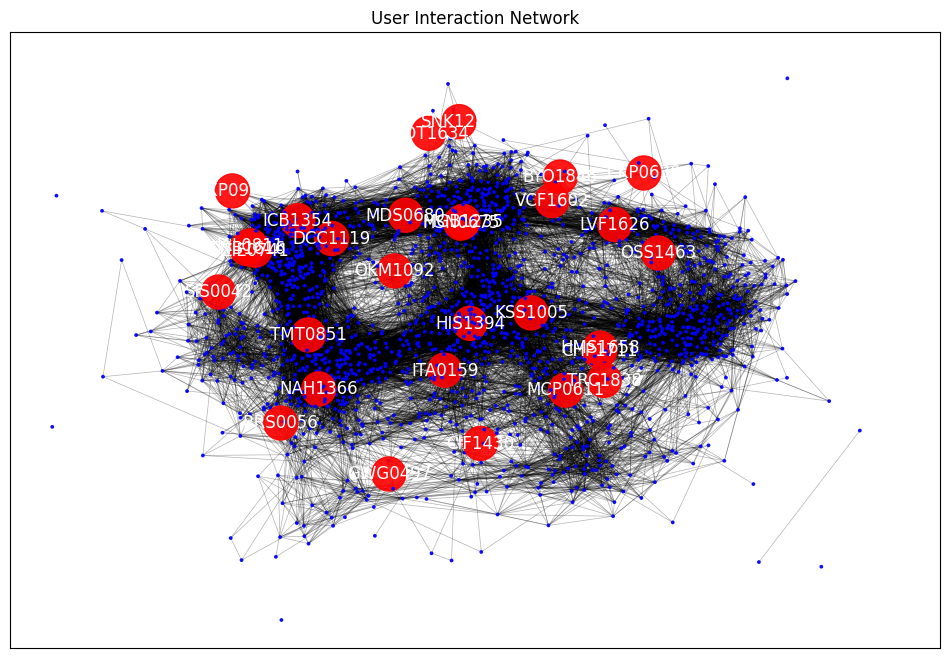

In [ ]:
malicious_node_size = 600  # Larger size for visibility
default_node_size = 3
node_colors = [G.nodes[n]['color'] for n in G.nodes()]
node_sizes = [malicious_node_size if data['color'] == 'red' else default_node_size for _, data in G.nodes(data=True)]

plt.figure(figsize=(12, 8))

# Generate a spring layout with increased space between nodes
pos = nx.spring_layout(G, k=0.3, iterations=50)  # Adjust k and iterations for better spacing

# Draw nodes with higher opacity for visibility
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)

# Draw edges with reduced width and transparency
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)

# Draw labels for malicious nodes with a larger font size and white font color for visibility
malicious_labels = {n: n if d['color'] == 'red' else '' for n, d in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=malicious_labels, font_size=12, font_color='white')

# Add a title and show the plot without axis for a cleaner look
plt.title('User Interaction Network')
# plt.axis('off')  # Hide the axis for a neater presentation
plt.show()

One user TNB1616 was always classified as a false negative for all 6 models.

In [ ]:
# Decision Tree
print(dt_data[dt_data["User"] =="TNB1616"])

print(dt_data[(dt_data["Actual"] == True) & (dt_data["Prediction"] == False)])

print("\n Number of instances with the same decision path: " + str(len(dt_data[dt_data["Decision Path"] == "[0, 1, 2, 4]"])))


        User  Actual  Prediction Decision Path  GINI Confidence of Prediction  \
224  TNB1616    True       False  [0, 1, 2, 4]                   1.110223e-16   

     normal_prob  malicious_prob  
224     0.925581        0.074419  
        User  Actual  Prediction Decision Path  GINI Confidence of Prediction  \
60   OKM1092    True       False  [0, 1, 2, 4]                   1.110223e-16   
224  TNB1616    True       False  [0, 1, 2, 4]                   1.110223e-16   
290  MCP0611    True       False  [0, 1, 2, 3]                   1.712135e-01   
318  TMT0851    True       False  [0, 1, 2, 4]                   1.110223e-16   

     normal_prob  malicious_prob  
60      0.925581        0.074419  
224     0.925581        0.074419  
290     0.996160        0.003840  
318     0.925581        0.074419  

 Number of instances with the same decision path: 59


For DT, seems like 3/4 of our true positives have the same decision path. and in the whole dataset 59 of the 

In [ ]:
# Decision Tree
print(smote_dt_data[smote_dt_data["User"] =="TNB1616"])

print(smote_dt_data[(smote_dt_data["Actual"] == True) & (smote_dt_data["Prediction"] == False)])

print("\n Number of instances with the same decision path: " + str(len(smote_dt_data[smote_dt_data["Decision Path"] == "[0, 1, 2]"])))

        User  Actual  Prediction Decision Path  GINI Confidence of Prediction  \
224  TNB1616    True       False     [0, 1, 2]                            1.0   

     normal_prob  malicious_prob  
224          1.0             0.0  
        User  Actual  Prediction Decision Path  GINI Confidence of Prediction  \
224  TNB1616    True       False     [0, 1, 2]                            1.0   
318  TMT0851    True       False     [0, 1, 2]                            1.0   

     normal_prob  malicious_prob  
224          1.0             0.0  
318          1.0             0.0  

 Number of instances with the same decision path: 322


For decision tree we can investigate the model by looking at the deicsion path. We see that the decision path is the same for both false negatives. However there are 322 instances in the dataset with the same decision path. 

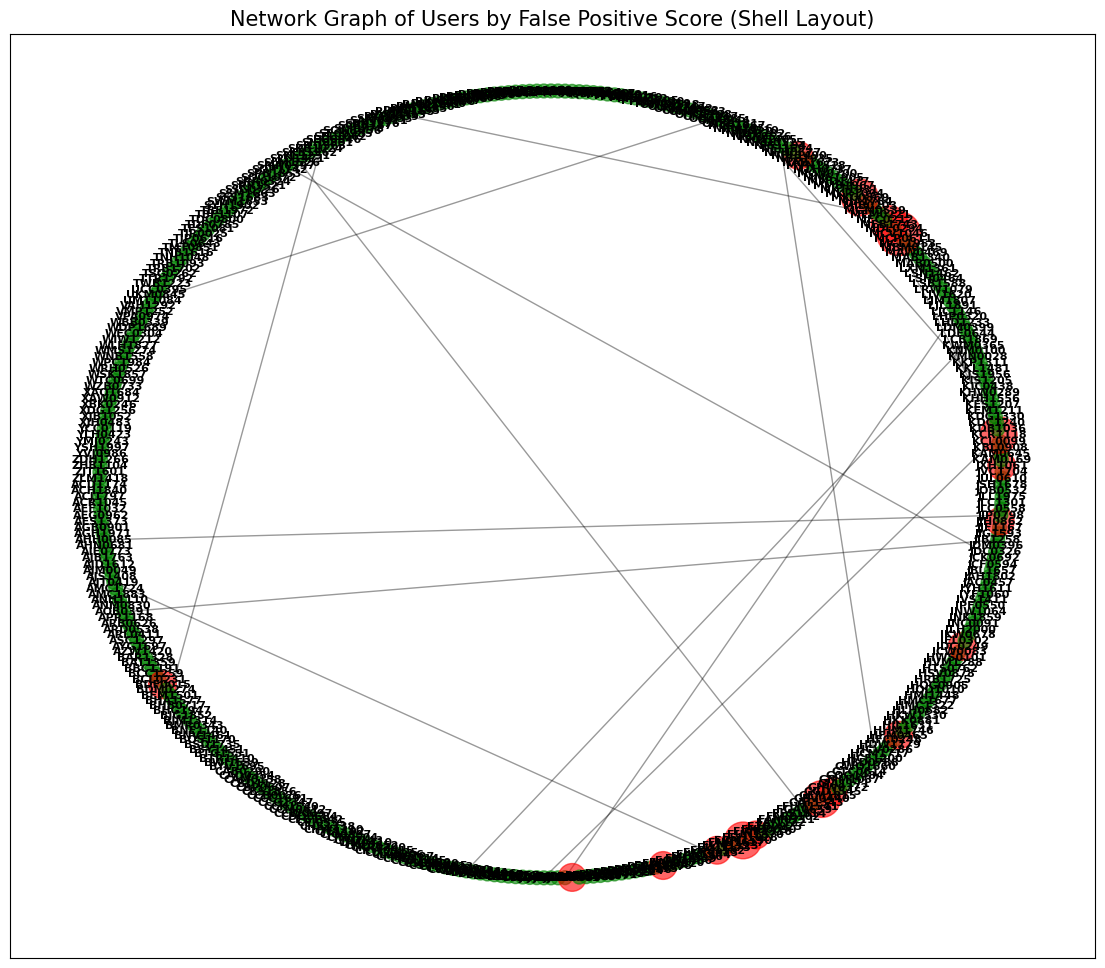

In [ ]:
G = nx.Graph()

# Add nodes with attributes for high and low false positives
for index, row in fds.iterrows():  # Assuming 'fds' is your DataFrame with user data
    G.add_node(row['User'], 
               size=row['fp']*300 + 100,  # Base size + scaled by FP score
               fp=row['fp'], 
               color='red' if row['fp'] >= 1 else 'green')  # Red for high FP, green for low FP

# Add edges randomly for demonstration (You might want to use actual relationships)
users = list(fds['User'])
for user in users:
    if random.random() > 0.95:  # Creating a sparse graph
        G.add_edge(user, random.choice(users))

# Set node positions using the Shell layout
shell_layout = nx.shell_layout(G)  # This might need adjustments based on your exact dataset

# Get sizes and colors for nodes
sizes = [G.nodes[node]['size'] for node in G]
colors = [G.nodes[node]['color'] for node in G]

# Draw the network graph
plt.figure(figsize=(14, 12))
nx.draw_networkx_nodes(G, shell_layout, node_size=sizes, node_color=colors, alpha=0.6)
nx.draw_networkx_edges(G, shell_layout, alpha=0.4)
nx.draw_networkx_labels(G, shell_layout, font_size=8, font_color='black', font_weight='bold')

# Add a title and display the plot
plt.title('Network Graph of Users by False Positive Score (Shell Layout)', size=15)
plt.show()

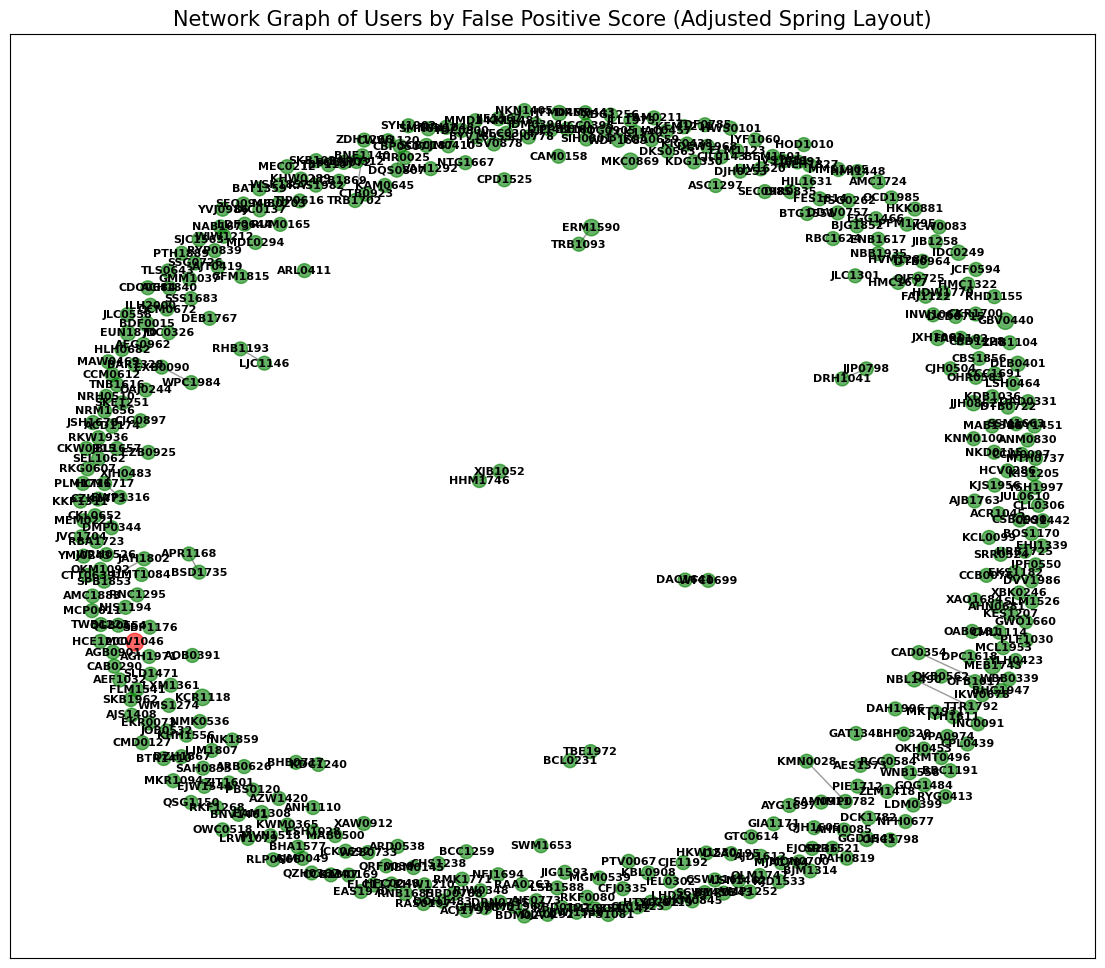

In [ ]:
# Set node positions using an adjusted Spring layout
spring_pos = nx.spring_layout(G, k=0.15)  # Increase k to push nodes further apart

# Draw the network graph using the adjusted layout
plt.figure(figsize=(14, 12))
nx.draw_networkx_nodes(G, spring_pos, node_size=sizes, node_color=colors, alpha=0.6)
nx.draw_networkx_edges(G, spring_pos, alpha=0.4)
nx.draw_networkx_labels(G, spring_pos, font_size=8, font_color='black', font_weight='bold')

# Add a title and display the plot
plt.title('Network Graph of Users by False Positive Score (Adjusted Spring Layout)', size=15)
plt.show()


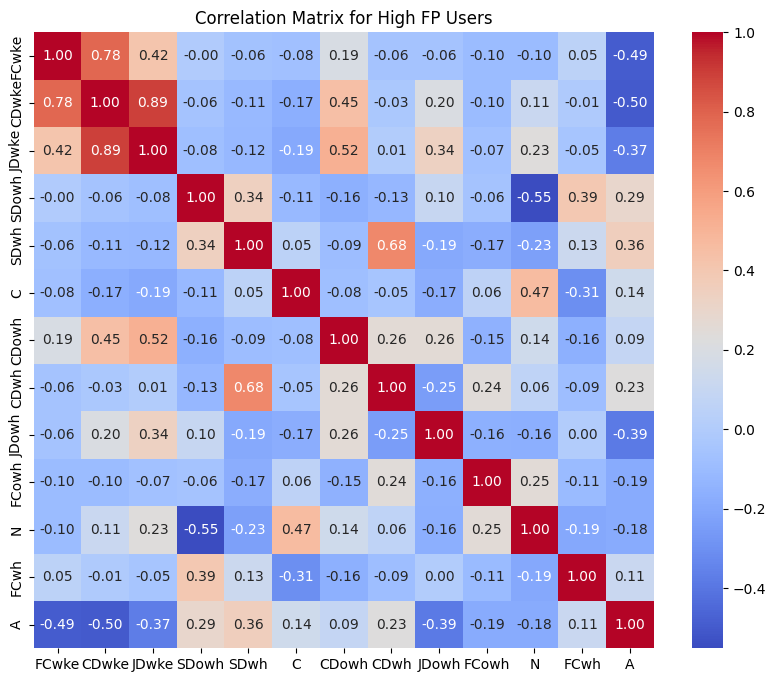

In [ ]:

corr_matrix = high_fp_features.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix for High FP Users')
plt.show()

- There is a significant overlap in file copying behavior irrespective of the time, indicated by high correlations between file copying features.
- Personality traits, particularly Agreeableness, seem to inversely correlate with file copying behaviors, suggesting a possible psychological aspect to the behaviors leading to false positives.

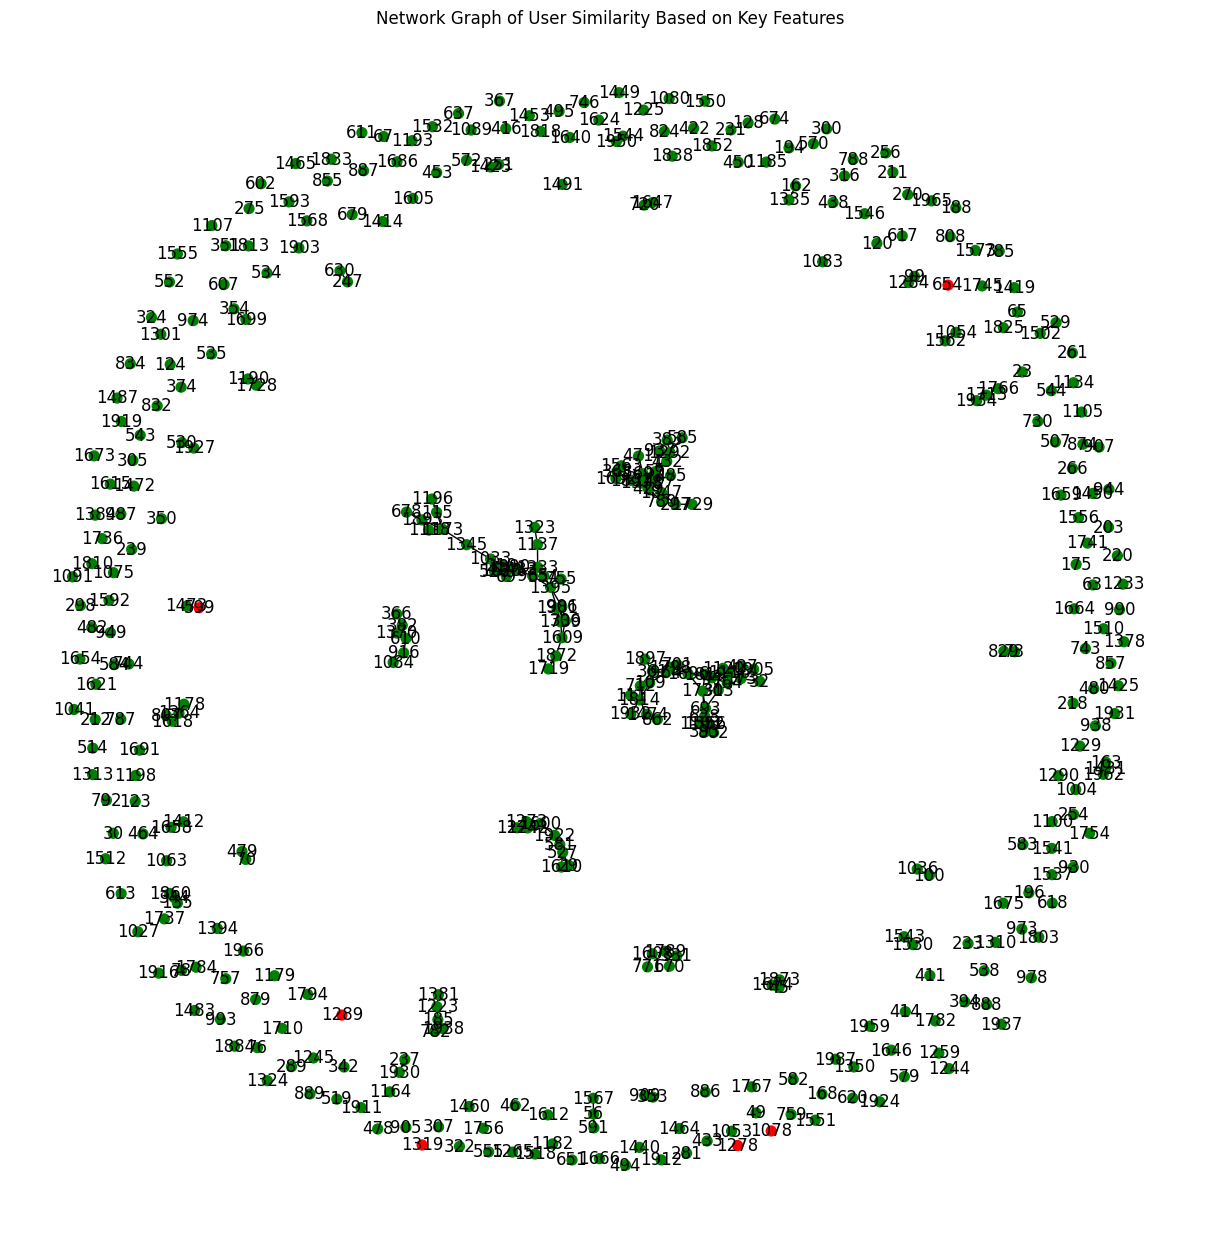

In [ ]:
combined = pd.concat([high_fp, low_fp])
scaler = StandardScaler()
combined_scaled = scaler.fit_transform(combined[features])
combined_scaled = pd.DataFrame(combined_scaled, columns=features, index=combined.index)

# Create a graph
G = nx.Graph()

# Add nodes with type based on FP score
for user in combined.index:
    G.add_node(user, fp=combined.loc[user, 'fp'])

# Add edges based on cosine similarity between feature vectors
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(combined_scaled)

for i in range(len(similarity_matrix)):
    for j in range(i + 1, len(similarity_matrix)):
        if similarity_matrix[i, j] > 0.95:  # threshold for similarity
            G.add_edge(combined.index[i], combined.index[j])

# Draw the network graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color=['red' if G.nodes[n]['fp'] >= 2 else 'green' for n in G.nodes], with_labels=True, node_size=50)
plt.title('Network Graph of User Similarity Based on Key Features')
plt.show()

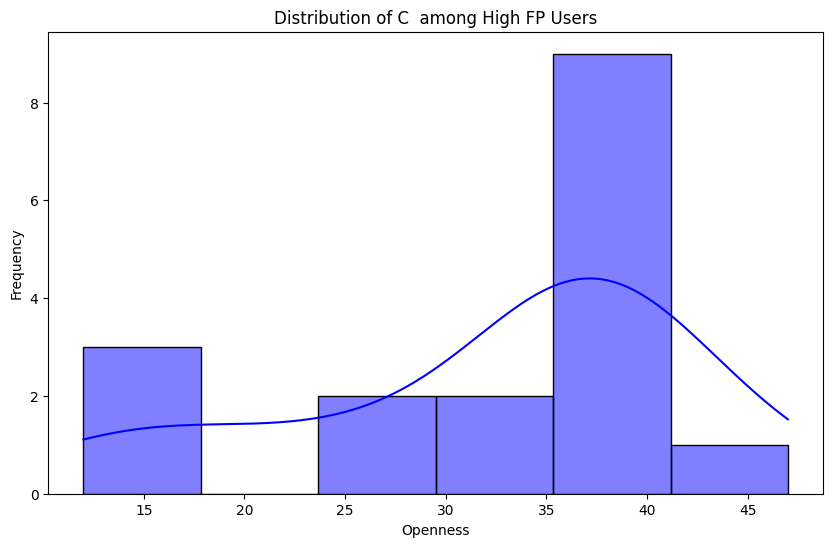

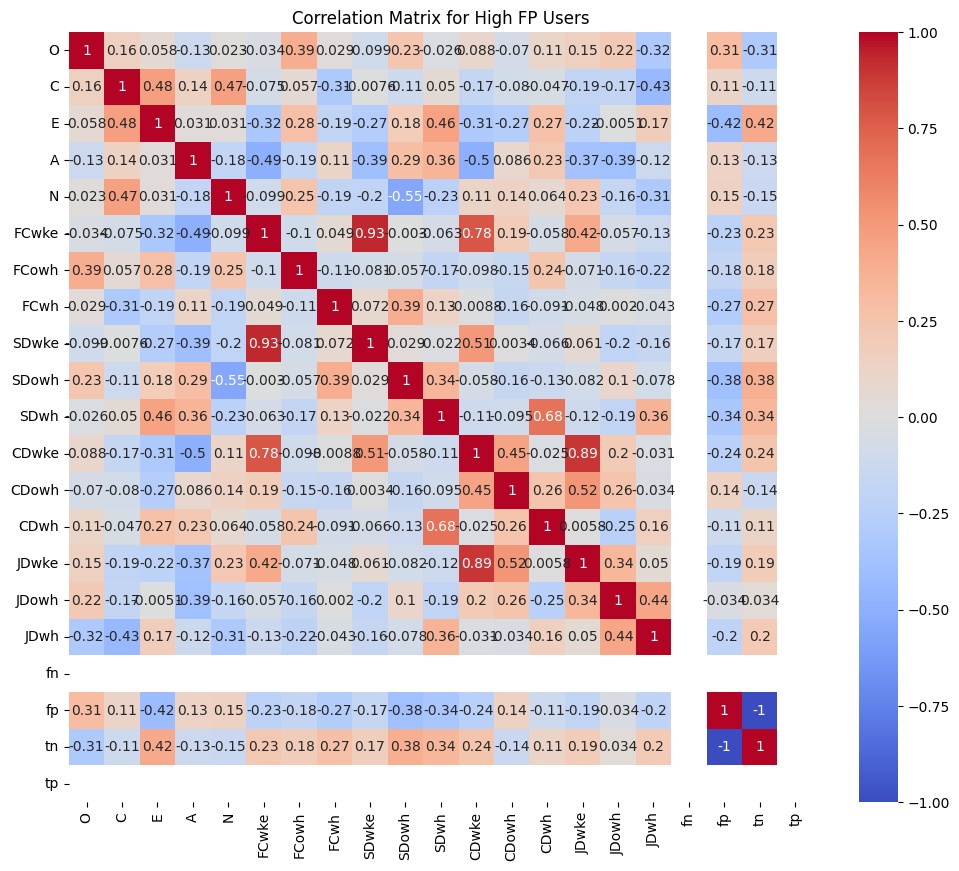

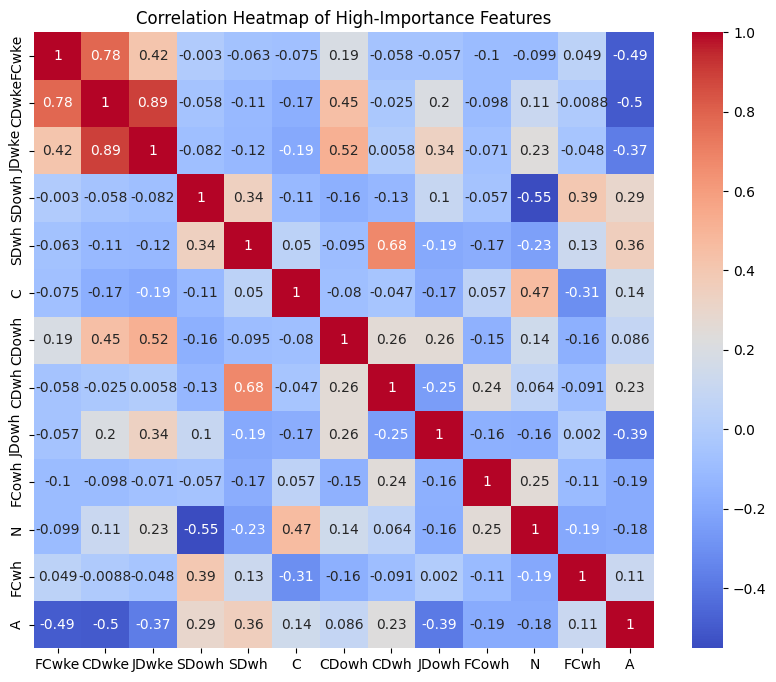

In [ ]:
high_fp_users = fds[fds['fp'] > 0] 
high_importance_features = ['FCwke', 'CDwke', 'JDwke', 'SDowh', 'SDwh', 'C', 'CDowh', 'CDwh', 'JDowh', 'FCowh', 'N', 'FCwh', 'A'] 

plt.figure(figsize=(10, 6))
sns.histplot(high_fp_users['C'], kde=True, color='blue')
plt.title('Distribution of C  among High FP Users')
plt.xlabel('Openness')
plt.ylabel('Frequency')
plt.show()

numeric_cols = high_fp_users.select_dtypes(include=[np.number])  # only use numeric columns
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for High FP Users')
plt.show()

corr = high_fp_users[high_importance_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of High-Importance Features')
plt.show()

In [ ]:
def merge_classification_results(models, actual_condition, predicted_condition, suffix):
    classification_results = []
    for model_data in models:
        classification_results.append(model_data[(model_data['Actual'] == actual_condition) & (model_data['Prediction'] == predicted_condition)])

    merged_data = fds.copy() 
    for idx, result_data in enumerate(classification_results):
        merged_data = pd.merge(merged_data, result_data[['User']], on='User', how='left', suffixes=('', '_{}'.format(suffix[idx])))

    return classification_results, merged_data

fp_all, false_positives_data = merge_classification_results(models, False, True, ['fp']*len(models))
fn_all, false_negatives_data = merge_classification_results(models, True, False, ['fn']*len(models))
tp_all,true_positives_data = merge_classification_results(models, True, True, ['tp']*len(models))
tn_all, true_negatives_data = merge_classification_results(models, False, False, ['tn']*len(models))

# Merge model results 
def merge_intersection_data(fp_fn_tp_tn_all):
    intersection_users = set(fp_fn_tp_tn_all[0]['User'])
    for df in fp_fn_tp_tn_all[1:]:
        intersection_users = intersection_users.intersection(df['User'])

    merged_intersection_data = fds[fds['User'].isin(intersection_users)]

    for df in fp_fn_tp_tn_all:
        merged_intersection_data = pd.merge(merged_intersection_data, df[['User']], on='User', how='left')

    return merged_intersection_data

merged_fp_data = merge_intersection_data(fp_all)
merged_fn_data = merge_intersection_data(fn_all)
merged_tp_data = merge_intersection_data(tp_all)
merged_tn_data = merge_intersection_data(tn_all)

In [ ]:
# Check
for i, lst in enumerate(fp_all):
    print(model_name[i])
    print(len(lst))

dt_data
0
smote_dt_data
9
svm_data
0
smote_svm_data
1
nn_data
7
smote_nn_data
7


In [ ]:
print(len(merged_fp_data),len(merged_fn_data), len(merged_tp_data),len(merged_tn_data))
merged_fn_data

0 1 0 379


,User,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh,malicious
0,TNB1616,33,38,10,43,29,0,12,61,0,206,605,0,9,15,0,123,248,True


One user TNB1616 was always classified as a false negative for all 6 models.

In [ ]:
false_positives_data

,User,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh,malicious
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246,False
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679,False
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025,False
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2,False
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494,False
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322,False
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7,False
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810,False
